In [1]:
import pandas as pd

intents = pd.read_csv('intents.csv', header=0)

In [2]:
intents = intents.sample(len(intents))
intents

,query,intent
98,"howdy, what's new",greeting
1051,bye now,goodbye
334,the answer is definitely no,no
233,"yeah that's right, so true",yes
473,i'd like to have a conversation,add_entry
...,...,...
100,"please cancel what you are doing, i've changed...",cancel
261,yeah,yes
18,it's good to see you,greeting
35,hi there alexa,greeting


In [3]:
labels = intents.intent.unique()

In [4]:
print(labels)

['greeting' 'goodbye' 'no' 'yes' 'add_entry' 'oos' 'cancel' 'entry_query'
 ' no']


In [5]:
import string

def lower(text):
    result = " ".join([word.lower() for word in text.split()])
    return result

def remove_punc(text):
    remove = str.maketrans('', '', (string.punctuation + '£'))
    return text.translate(remove)

def remove_nums(text):
    remove = str.maketrans('', '', string.digits)
    return text.translate(remove)

In [6]:
intents['query'] = intents['query'].astype(str)
intents['query'] = intents['query'].apply(lower)
intents['query'] = intents['query'].apply(remove_punc)
intents['query'] = intents['query'].apply(remove_nums)


In [7]:
labels

array(['greeting', 'goodbye', 'no', 'yes', 'add_entry', 'oos', 'cancel',
       'entry_query', ' no'], dtype=object)

In [8]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import numpy as np

encoder = LabelEncoder()
encoder.fit(labels)

Y_train = encoder.transform(intents['intent'])

n_classes = np.max(Y_train) + 1

Y_train = np_utils.to_categorical(Y_train, n_classes)

label_names=encoder.classes_

In [9]:
import matplotlib.pyplot as plt

In [10]:
def train_val_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])

    plt.title(f'History of {metric} over epochs')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['training '+metric, 'validation '+metric])

    plt.show()

In [11]:
max_len = 128

In [12]:
from keras.layers import TextVectorization

vectorizer = TextVectorization(output_sequence_length=max_len)

vectorizer.adapt(intents['query'])

vocab = vectorizer.get_vocabulary()

word_index = dict(zip(vocab, range(len(vocab))))

X_train = vectorizer(intents['query'])


In [13]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

In [14]:
cor_path = datapath("lee_background.cor")

ft = FastText(vector_size=100)

train_ft = intents['query'].tolist()

train_ft = [x.split() for x in train_ft]

ft.build_vocab(corpus_file=cor_path)

ft.train(
    corpus_file=cor_path, epochs=ft.epochs,
    total_examples=ft.corpus_count, total_words=ft.corpus_total_words,
)

ft.build_vocab(train_ft, update=True)
ft.train(train_ft, total_examples=len(train_ft), epochs=ft.epochs)

(14309, 29980)

In [15]:
n_tokens = len(vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

matrix = np.zeros((n_tokens, embedding_dim))

for word, i in word_index.items():
    try:
        embedding_vector = ft.wv[word]

        if embedding_vector is not None:
            matrix[i] = embedding_vector
            hits += 1
        else:
            matrix[i] = np.random.randn(embedding_dim)
            misses += 1
    except Exception as e:
        matrix[i] = np.random.randn(embedding_dim)
        print(e)
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 923 words (0 misses)


In [16]:
from tensorflow import keras
import keras.layers as l
import tensorflow as tf

In [17]:
inputs = keras.Input(shape=(max_len,))

embedding_layer = l.Embedding(
    n_tokens,
    embedding_dim,
    input_length=max_len,
    embeddings_initializer=tf.keras.initializers.Constant(matrix),
    trainable=True
)(inputs)

reshape = l.Reshape((max_len, 100, 1))(embedding_layer)

conv_0 = l.Conv2D(100, kernel_size=(3, 100), activation='relu')(reshape)
conv_1 = l.Conv2D(100, kernel_size=(4, 100), activation='relu')(reshape)
conv_2 = l.Conv2D(100, kernel_size=(5, 100), activation='relu')(reshape)

maxpool_0 = l.MaxPooling2D(pool_size=(max_len - 3 + 1, 1))(conv_0)
maxpool_1 = l.MaxPooling2D(pool_size=(max_len - 4 + 1, 1))(conv_1)
maxpool_2 = l.MaxPooling2D(pool_size=(max_len - 5 + 1, 1))(conv_2)

concatenate = l.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])

flatten = l.Flatten()(concatenate)

dropout = l.Dropout(0.5)(flatten)

output = l.Dense(n_classes, activation='softmax')(dropout)

model = keras.Model(inputs=inputs, outputs=output)

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint(
    'intents.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    mode='auto'
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=20,
    min_delta=0.001,
    verbose=1, 
    mode='auto'
)

callbacks = [mc, es, rlr]

In [19]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
)

In [20]:
hist = model.fit(X_train, Y_train, epochs=200, shuffle=True, validation_split = 0.10, callbacks=callbacks)

Epoch 1/200
30/30 [==============================] - 5s 15ms/step - loss: 2.0196 - accuracy: 0.2719 - val_loss: 1.9504 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 1.9499 - accuracy: 0.2896 - val_loss: 1.9239 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 1.9164 - accuracy: 0.2885 - val_loss: 1.9056 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 1.9002 - accuracy: 0.2917 - val_loss: 1.8860 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 5/200
30/30 [==============================] - 0s 7ms/step - loss: 1.8771 - accuracy: 0.3052 - val_loss: 1.8738 - val_accuracy: 0.3271 - lr: 1.0000e-04
Epoch 6/200
30/30 [==============================] - 0s 7ms/step - loss: 1.8541 - accuracy: 0.3187 - val_loss: 1.8464 - val_accuracy: 0.3458 - lr: 1.0000e-04
Epoch 7/200
30/30 [==============================] 

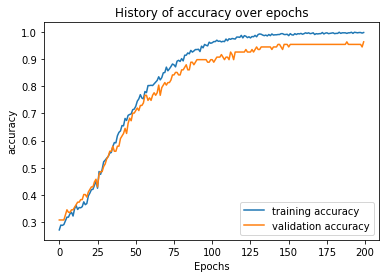

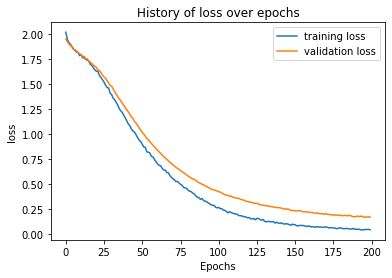

In [21]:
train_val_graph(hist, "accuracy")
train_val_graph(hist, "loss")

In [22]:
import pickle
pickle.dump(encoder, open("encoder.pkl", "wb"))
pickle.dump({'config': vectorizer.get_config(), 'weights': vectorizer.get_weights()}, open("vectoriser.pkl", "wb"))

In [23]:
def get_e2e_model(m):
    input_str = keras.Input(shape=(1,), dtype="string")

    x = vectorizer(input_str)  # vectorize

    output = m(x)

    e2e = keras.Model(input_str, output)

    return e2e

In [24]:
from keras.models import load_model, save_model

model = load_model('intents.h5')
e2e_model = get_e2e_model(model)

In [27]:
test_sents = [["i want to talk about today"], ["see ya"], ["yes that is correct"], [
    "let's stop talking"], ["that's not right"], ["not quite"], ['tell me what i did yesterday'],
    ['tell me about yesterday'], ['i want to take my time'], ['what time is it'], ["order pizza to my house please"]]

for sentence in test_sents:
    sentence[0] = lower(sentence[0])
    sentence[0] = remove_nums(sentence[0])
    sentence[0] = remove_punc(sentence[0])

probabilities = e2e_model.predict(test_sents)

for i in tf.range(len(probabilities)):
    print("The input '" +test_sents[i][0] + "' is labelled with the intent \"" + label_names[np.argmax(probabilities[i])] 
    + "\" with " + str(float('{0:.2f}'.format(np.max(probabilities[i])*100))) + "% certainty")

The input 'i want to talk about today' is labelled with the intent "add_entry" with 99.95% certainty
The input 'see ya' is labelled with the intent "goodbye" with 94.8% certainty
The input 'yes that is correct' is labelled with the intent "yes" with 99.87% certainty
The input 'lets stop talking' is labelled with the intent "cancel" with 99.89% certainty
The input 'thats not right' is labelled with the intent "no" with 93.96% certainty
The input 'not quite' is labelled with the intent "no" with 97.87% certainty
The input 'tell me what i did yesterday' is labelled with the intent "entry_query" with 99.57% certainty
The input 'tell me about yesterday' is labelled with the intent "entry_query" with 95.15% certainty
The input 'i want to take my time' is labelled with the intent "oos" with 82.12% certainty
The input 'what time is it' is labelled with the intent "oos" with 97.68% certainty
The input 'order pizza to my house please' is labelled with the intent "oos" with 72.58% certainty
